# ![TensorFlow](https://img.shields.io/badge/TensorFlow-%23FF6F00.svg?style=for-the-badge&logo=TensorFlow&logoColor=white) **CHAPTER 14 - DEEP COMPUTER VISION USING CONVOLUTIONAL NEURAL NETWORKS**

---

## **SETUP:**

In [3]:
# %load ../initial_settings.py
"""
Initial settings for data analysis and machine learning.
Use this with: %load ../initial_settings.py
"""

import os
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import keras_tuner as kt
from packaging import version

# This notebook requires Python 3.7 or above and Scikit-Learn 1.0.1 or above.
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# And TensorFlow 2.8 or above.
assert version.parse(tf.__version__) >= version.parse("2.8.0")

# Graphviz source.
os.environ["PATH"] += os.pathsep + "C:/Programy/Graphviz/bin/"

# Default settings for matplotlib.
DARK_BLUE = "#03002e"
LIGHT_GRAY = "#8f8f99"

plt.rc("font", size=14)
plt.rc("legend", fontsize=14)
plt.rc("text", color=DARK_BLUE)

plt.rc("axes", labelsize=14)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelpad=10)
plt.rc("axes", labelcolor=DARK_BLUE)
plt.rc("axes", grid=True)

plt.rc("xtick", labelsize=12, color=DARK_BLUE)
plt.rc("ytick", labelsize=12, color=DARK_BLUE)
plt.rc("xtick.major", pad=10)
plt.rc("ytick.major", pad=10)

plt.rc("grid", color=LIGHT_GRAY)
plt.rc("grid", linestyle="dashed")
plt.rc("grid", linewidth=0.5)
plt.rc("grid", alpha=0.5)

# Create a directory for matplotlib images.
IMAGES_PATH = Path("images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(
    fig_id, tight_layout=True, fig_extension="png", resolution=300, facecolor="w"
):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor=facecolor)


In [3]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

---

## **CONVOLUTIONAL LAYERS:**

### **IMPLEMENTING CONVOLUTIONAL LAYERS WITH KERAS:**

Let's load two sample images, rescale their pixel values to 0-1, and center crop them to small 70×120 images:

In [6]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1.0 / 255.0)(images)


In [7]:
images.shape

TensorShape([2, 70, 120, 3])

In [8]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)


In [9]:
fmaps.shape

TensorShape([2, 64, 114, 32])

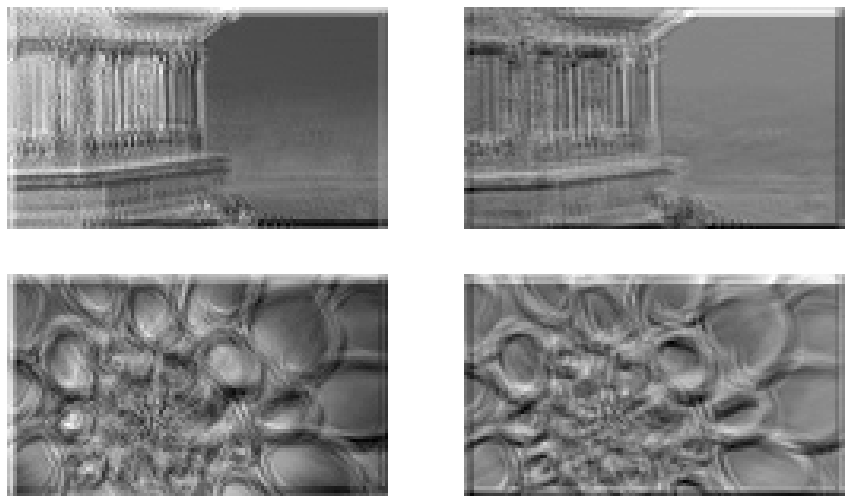

In [18]:
plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()


As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

Now let's use zero-padding:

In [12]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same")
fmaps = conv_layer(images)


In [13]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [24]:
conv_layer = tf.keras.layers.Conv2D(
    filters=32, kernel_size=7, padding="same", strides=2
)
fmaps = conv_layer(images)
fmaps.shape


TensorShape([2, 35, 60, 32])

In [28]:
# extra code – this utility function can be useful to compute the size of the
#              feature maps output by a convolutional layer. It also returns
#              the number of ignored rows or columns if padding="valid", or the
#              number of zero-padded rows or columns if padding="same"."""


def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding == "valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored

    output_size = (input_size - 1) // strides + 1
    num_padded = (output_size - 1) * strides + kernel_size - input_size
    return output_size, num_padded


conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")


(array([35, 60], dtype=int32), array([5, 5]))

Let's now look at the weights:

In [29]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [30]:
biases.shape

(32,)

In [32]:
# extra code – shows how to use the tf.nn.conv2d() operation

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases


Let's manually create two filters full of zeros, except for a vertical line of 1s in the first filter, and a horizontal one in the second filter (just like in Figure 14–5). The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice you will probably never need to create filters manually, since the convolutional layers will learn them automatically.

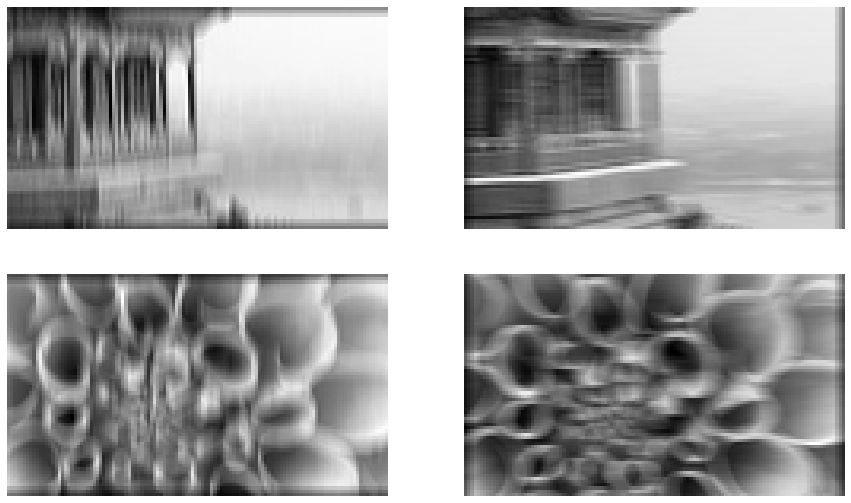

In [34]:
# extra code – shows how to manually create two filters to get images similar
#              to those in Figure 14–5.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()


Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figure?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

---

## **POOLING LAYERS:**

### **IMPLEMENTING POOLING LAYERS WITH KERAS:**

#### **MAX POOLING:**

In [35]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)
output = max_pool(images)


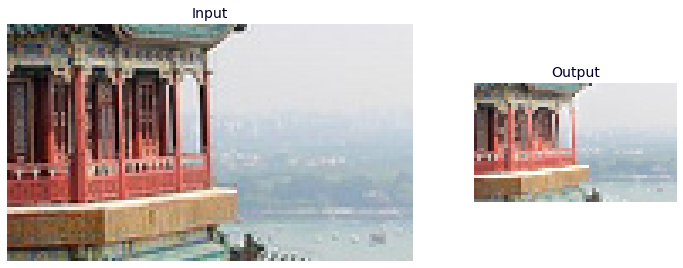

In [36]:
# extra code – this cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

#### **DEEP-WISE POOLING:**

In [37]:
# extra code – shows how to use the max_pool() op; only works on the CPU
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(
        fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"
    )
output.shape


TensorShape([2, 70, 120, 20])

In [38]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)


In [44]:
# extra code – shows that this custom layer gives the same result as max_pool()
np.allclose(DepthPool(pool_size=3)(fmaps), output)


True

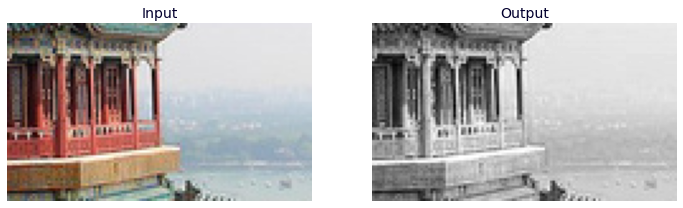

In [46]:
# extra code – computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()


#### **GLOBAL AVERAGE POOLING:**

In [47]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()


The following layer is equivalent:

In [48]:
global_avg_pool = tf.keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))


In [49]:
global_avg_pool(images)


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

---

## **CNN ARCHITECTURES:**

### **TACKLING FASHION MNIST WITH A CNN:**

In [50]:
# extra code – loads the mnist dataset, add the channels axis to the inputs,
#              scales the values to the 0-1 range, and splits the dataset
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist

X_train_full = np.expand_dims(X_train_full.astype(np.float32), axis=-1) / 255.0
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255.0

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


In [51]:
from functools import partial

tf.random.set_seed(42)

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal",
)

model = tf.keras.Sequential(
    [
        DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=128, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            units=64, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=10, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=["accuracy"],
)

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
)

score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)


Epoch 1/10
1719/1719 [==============================] - 22s 11ms/step - loss: 0.6663 - accuracy: 0.7693 - val_loss: 0.3480 - val_accuracy: 0.8688
Epoch 2/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.3828 - accuracy: 0.8729 - val_loss: 0.3282 - val_accuracy: 0.8816
Epoch 3/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3252 - accuracy: 0.8915 - val_loss: 0.2815 - val_accuracy: 0.8984
Epoch 4/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2968 - accuracy: 0.9011 - val_loss: 0.2681 - val_accuracy: 0.8994
Epoch 5/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2733 - accuracy: 0.9081 - val_loss: 0.2672 - val_accuracy: 0.9062
Epoch 6/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2596 - accuracy: 0.9118 - val_loss: 0.2531 - val_accuracy: 0.9100
Epoch 7/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2407 - accuracy: 0.9170 - val_loss: 0.2488 -

### **LENET-5:**

The famous LeNet-5 architecture had the following layers:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Out   | Fully connected | –    | 10       | –           | –      | RBF
 F6    | Fully connected | –    | 84       | –           | –      | tanh
 C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
 S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
 C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
 S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
 C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
 In    | Input           | 1    | 32 × 32  | –           | –      | –

There were a few tweaks here and there, which don't really matter much anymore, but in case you are interested, here they are:

* MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
* The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.
* Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 (page 8) in the [original paper](https://homl.info/lenet5) for details.
* The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.

### **IMPLEMENTING A RESNET-34 CNN USING KERAS:**

In [52]:
DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    strides=1,
    padding="same",
    kernel_initializer="he_normal",
    use_bias=False,
)


class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization(),
        ]

        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization(),
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)

        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)

        return self.activation(Z + skip_Z)


In [54]:
model = tf.keras.Sequential(
    [
        DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
    ]
)

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    if filters == prev_filters:
        strides = 1
    else:
        strides = 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


---

## **USING PRETRAINED MODELS FROM KERAS:**

In [55]:
model = tf.keras.applications.ResNet50(weights="imagenet")


In [56]:
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(
    height=224, width=224, crop_to_aspect_ratio=True
)(images)


In [58]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)


In [60]:
Y_proba = model.predict(inputs)
Y_proba.shape


1/1 [==============================] - 1s 1s/step


(2, 1000)

In [61]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")


Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.71%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.67%
  n11939491 - daisy        17.82%
  n03530642 - honeycomb    12.04%


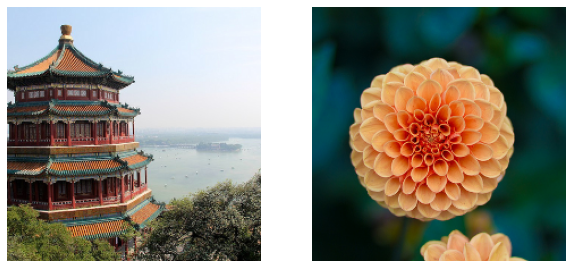

In [62]:
# extra code – displays the cropped and resized images

plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

---

## **PRETRAINED MODELS FOR TRANSFER LEARNING:**

In [69]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [65]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='C:\\Users\\Mateusz\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [70]:
dataset_size

3670

In [71]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [72]:
n_classes

5

In [73]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True,
)


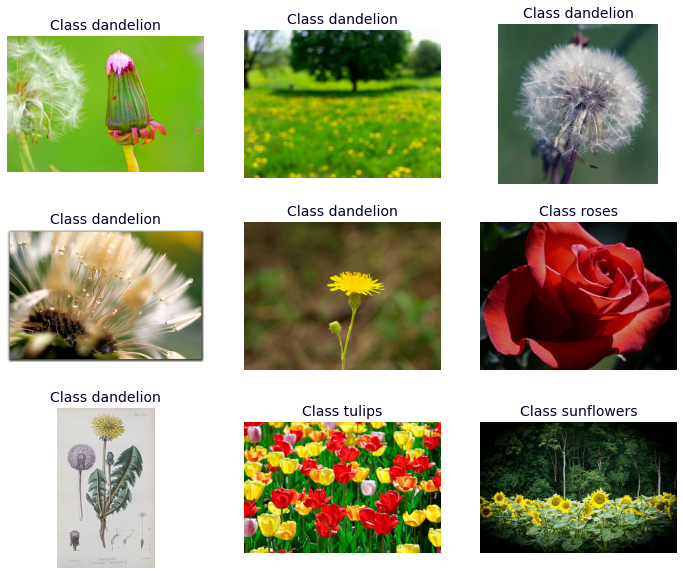

In [74]:
# extra code – displays the first 9 images in the validation set

plt.figure(figsize=(12, 10))
index = 0

for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class {class_names[label]}")
    plt.axis("off")

plt.show()


All three datasets contain individual images. We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a `Resizing` layer for this. We must also call the `tf.keras.applications.xception.preprocess_input()` function to preprocess the images appropriately for the Xception model. We will also add shuffling and prefetching to the training dataset.

In [75]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

preprocess = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
        tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input),
    ]
)

batch_size = 32

train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)


Let's take a look again at the first 9 images from the validation set: they're all 224x224 now, with values ranging from -1 to 1:

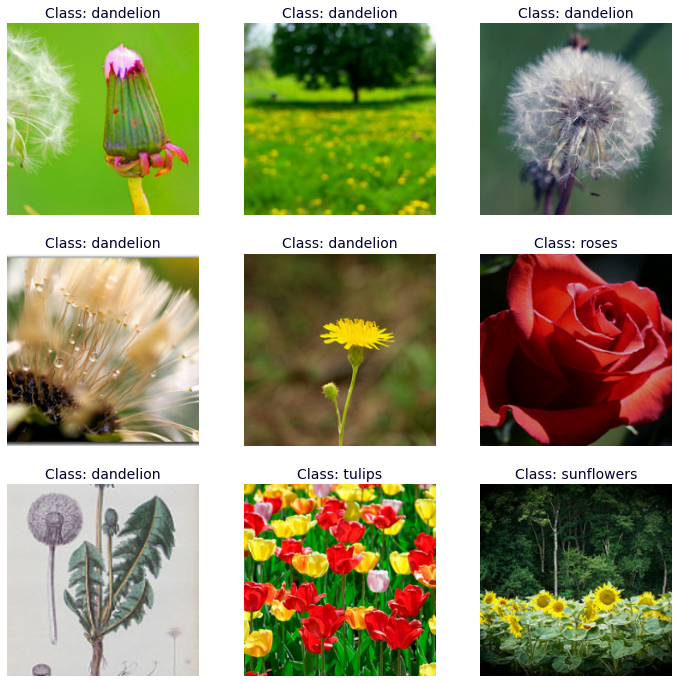

In [77]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()


In [78]:
tf.get_logger().setLevel("ERROR")


In [79]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
        tf.keras.layers.RandomRotation(factor=0.05, seed=42),
        tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    ]
)


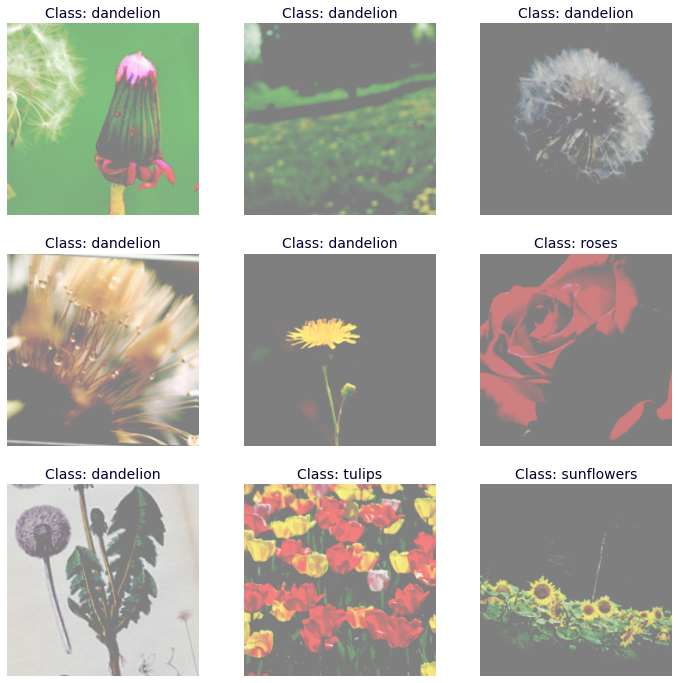

In [103]:
# extra code – displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()


Now let's load the pretrained model, without its top layers, and replace them with our own, for the flower classification task:

In [104]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(
    weights="imagenet", include_top=False
)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)


In [105]:
for layer in base_model.layers:
    layer.trainable = False


Let's train the model for a few epochs, while keeping the base model weights fixed:

In [106]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(train_set, validation_data=valid_set, epochs=3)


Epoch 1/3
86/86 [==============================] - 18s 168ms/step - loss: 0.7519 - accuracy: 0.8049 - val_loss: 0.7089 - val_accuracy: 0.8439
Epoch 2/3
86/86 [==============================] - 14s 154ms/step - loss: 0.3183 - accuracy: 0.9084 - val_loss: 0.6184 - val_accuracy: 0.8367
Epoch 3/3
86/86 [==============================] - 14s 153ms/step - loss: 0.1786 - accuracy: 0.9400 - val_loss: 0.7223 - val_accuracy: 0.8512


In [107]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

Now that the weights of our new top layers are not too bad, we can make the top part of the base model trainable again, and continue training, but with a lower learning rate:

In [108]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"],
)
history = model.fit(train_set, validation_data=valid_set, epochs=10)


Epoch 1/10
86/86 [==============================] - 30s 300ms/step - loss: 0.3074 - accuracy: 0.9033 - val_loss: 0.4091 - val_accuracy: 0.8838
Epoch 2/10
86/86 [==============================] - 26s 294ms/step - loss: 0.0400 - accuracy: 0.9873 - val_loss: 0.3945 - val_accuracy: 0.8911
Epoch 3/10
86/86 [==============================] - 26s 296ms/step - loss: 0.0172 - accuracy: 0.9945 - val_loss: 0.3471 - val_accuracy: 0.9038
Epoch 4/10
86/86 [==============================] - 26s 297ms/step - loss: 0.0134 - accuracy: 0.9953 - val_loss: 0.3082 - val_accuracy: 0.9056
Epoch 5/10
86/86 [==============================] - 26s 297ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.3098 - val_accuracy: 0.9020
Epoch 6/10
86/86 [==============================] - 26s 301ms/step - loss: 0.0104 - accuracy: 0.9967 - val_loss: 0.3615 - val_accuracy: 0.8984
Epoch 7/10
86/86 [==============================] - 26s 301ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.3366 - val_accuracy: 0.8984

---

## **CLASSIFICATION AND LOCALIZATION:**

In [109]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(
    weights="imagenet", include_top=False
)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])
model.compile(
    loss=["sparse_categorical_crossentropy", "mse"],
    loss_weights=[0.8, 0.2],  # depends on what you care most about
    optimizer=optimizer,
    metrics=["accuracy"],
)


In [113]:
# extra code – fits the model using random target bounding boxes (in real life
#              you would need to create proper targets instead)


def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)


train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(16).prefetch(1)
fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)


Epoch 1/2
10/10 [==============================] - 5s 299ms/step - loss: 1.2463 - dense_1_loss: 1.4935 - dense_2_loss: 0.2575 - dense_1_accuracy: 0.3625 - dense_2_accuracy: 0.2688
Epoch 2/2
10/10 [==============================] - 4s 307ms/step - loss: 0.9575 - dense_1_loss: 1.1447 - dense_2_loss: 0.2088 - dense_1_accuracy: 0.6187 - dense_2_accuracy: 0.2250


---

## **EXTRA MATERIAL - HOW mAP RELATES TO PRECISION/RECALL:**

In [1]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

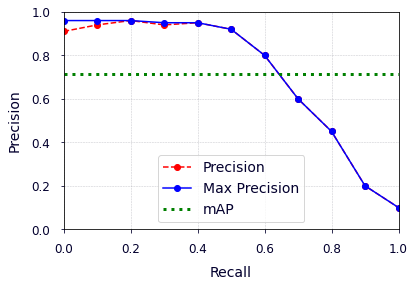

In [4]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()